In [1]:
#!pip install tensorflow_text  

In [2]:
import numpy as np
import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
use_builtins = True

In [4]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [5]:
!pip install tweet-preprocessor

In [6]:
import pandas as pd
data=pd.read_csv("/kaggle/input/phincparallel-hinglish-corpus-machine-translation/English-Hindi code-mixed parallel corpus.csv")
data=data.dropna()
import preprocessor as p
data['Sentence']=data['Sentence'].apply(lambda x: p.clean(x))
data['English_Translation']=data['English_Translation'].apply(lambda x: p.clean(x))
data['len_sen']=data['Sentence'].apply(lambda x: len(x.split(' ')))
data=data[data['len_sen']<=20]
data

,Sentence,English_Translation,len_sen
1,uske liye toh bahot kuch karna padega ye pappi...,"rat we should a lot more for that, by this evi...",13
2,yehi to hum semjhane ki koshish kar rahe hain....,"ehi, this is what i'm expecting you to underst...",20
3,cake kaha hai ??,is Dramebajakudi where is the cake?,4
4,i'm in hawaii at the moment . home next friday...,user Don't want to come home next friday becau...,18
5,Jeet ka jashn aur shubah ki shuruat eating bre...,the celebration of a victory and the start of ...,15
...,...,...,...
13733,"Dr Kumar Vishwas: ""Koi deewana kehta hai.. koi...","Dr Kumar Vishwas: ""Some used to say lover.. So...",11
13734,Me: Aaj kuch toofani karte hai.Mom: Pani ki bo...,Me: Let's do some stormy today.Mom: Fill the w...,15
13735,"Pyar mangi to Jaan dengi,milk mango to kher de...","Ask for love we'll give life, ask for milk we'...",14
13736,kaale kaale baal gaal gore gore,black hair cheeks fair fair,6


In [7]:
inp=list(data["Sentence"])
targ=list(data['English_Translation'])

In [8]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 32

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [9]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'aur admin kaha busy ho yaar aj kal apk post k darshn durlabh ho gye h'
 b'Bihar me BJP ko Laloo se jyada nuksaan Shatrughan Sinha ne pahuchaya hai.'
 b'saare teacher kuch zyaada hi masti karte hain . . . .'
 b'Bhai ne driver ko fasa diya' b'andhe ho tum aur ignorant bhi'], shape=(5,), dtype=string)

tf.Tensor(
[b'and admin, where are you busy? man, these days your posts have become rare.'
 b'in bihar, shatrughan sinha hurt bjp more than laloo'
 b'all teachers have too much fun.' b'the man tricked the driver.'
 b'you are the one who is blind and ignorant as well'], shape=(5,), dtype=string)


In [10]:
example_text = tf.constant('Yahi haal hai')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'Yahi haal hai'
b'Yahi haal hai'


In [11]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [12]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Yahi haal hai
[START] yahi haal hai [END]


In [13]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(    # handles vocabulary extraction & conversion of i/p text to sequences of tokens
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

In [14]:
input_text_processor.adapt(inp)    # initializes the layer based on the data

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]
# Hinglish TextVectorization layer

['', '[UNK]', '.', '[START]', '[END]', 'hai', ',', '?', 'nahi', 'to']

In [15]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]
# English TextVectorization layer

['', '[UNK]', '[START]', '[END]', '.', ',', 'you', 'is', 'the', 'to']

In [16]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   3,   23, 1592,  123, 1428,   15,   55,  811,  109,    1],
       [   3,  222,   24,  400,   18, 2169,   16,  434, 2964, 3573],
       [   3,  340,  676,   33, 2016,   21, 3815,  121,   40,    2]])>

In [17]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] aur admin kaha busy ho yaar aj kal [UNK] post k [UNK] [UNK] ho gye h [END]    '

Text(0.5, 1.0, 'Mask')

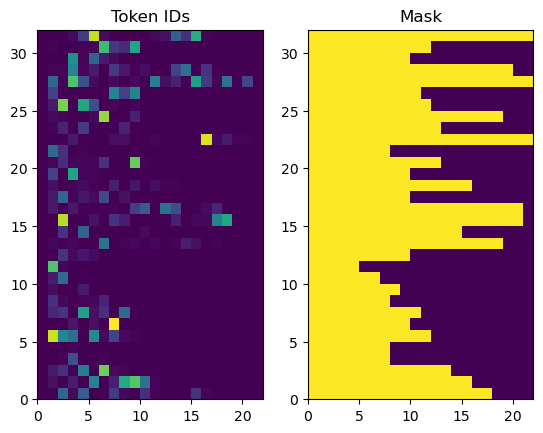

In [18]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [19]:
embedding_dim = 256
units = 1024

In [20]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

In [21]:
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (32,)
Input batch tokens, shape (batch, s): (32, 22)
Encoder output, shape (batch, s, units): (32, 22, 1024)
Encoder state, shape (batch, units): (32, 1024)


In [22]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [23]:
attention_layer = BahdanauAttention(units)

In [24]:
(example_tokens != 0).shape

TensorShape([32, 22])

In [25]:
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (32, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (32, 2, 22)


Text(0.5, 1.0, 'Mask')

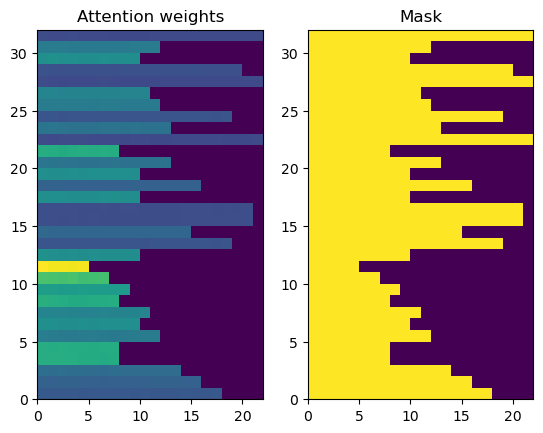

In [26]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')


In [27]:
attention_weights.shape

TensorShape([32, 2, 22])

In [28]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 640x480 with 0 Axes>

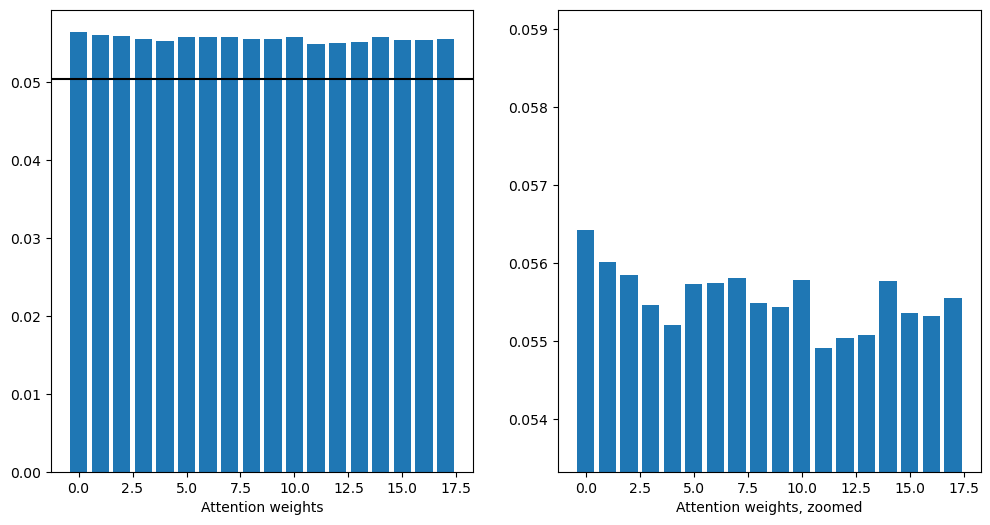

In [29]:
#@title
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

In [30]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [31]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [32]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [33]:
Decoder.call = call

In [34]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [35]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [36]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (32, 1, 5000)
state shape: (batch_size, dec_units) (32, 1024)


In [37]:
# sample token according to logits
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [38]:
# decode the token as first word of o/p
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['pi'],
       ['state'],
       ['thoda'],
       ['jealous'],
       ['bridge']], dtype='<U16')

In [39]:
# decoder generates second set of logits
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [40]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['comics'],
       ['picking'],
       ['aadmi'],
       ['laundry'],
       ['royal']], dtype='<U16')

In [41]:
# Loss function definition
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

In [42]:
# implementing training step
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [43]:
# Receiving batches of english & hinglish data
# Converting those raw text inputs to token-embeddings and masks.
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [44]:
TrainTranslator._preprocess = _preprocess

In [45]:
# training
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [46]:
TrainTranslator._train_step = _train_step

In [47]:
# executes the decoder and calculates the incremental loss and new decoder state 
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [48]:
TrainTranslator._loop_step = _loop_step

In [49]:
# testing the training step
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [50]:
np.log(output_text_processor.vocabulary_size())

8.517193191416236

In [51]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.8748107>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.8511405>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.808958>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.6879654>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.224312>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.1678834>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.8609805>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4468846>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3075323>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3261056>}

CPU times: user 31.2 s, sys: 1.72 s, total: 32.9 s
Wall time: 29.7 s


In [52]:
# maximizing performance while training
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [53]:
TrainTranslator._tf_train_step = _tf_train_step

In [54]:
translator.use_tf_function = True

In [55]:
translator.train_step([example_input_batch, example_target_batch])

2023-03-08 14:25:51.518145: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] function_optimizer failed: INVALID_ARGUMENT: Input 6 of node gradient_tape/while/while_grad/body/_526/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/PartitionedCall was passed variant from gradient_tape/while/while_grad/body/_526/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.
2023-03-08 14:25:51.626127: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: OUT_OF_RANGE: src_output = 25, but num_outputs is only 25
2023-03-08 14:25:51.721581: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:134] tfg_optimizer{tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export} failed: INVALID_ARGUMENT: Result #25 of node 'while/body/_1/while/decoder_1/gru_3/PartitionedCall' is out of bounds
	when importing GraphDef to MLIR module in 

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.373391>}

In [56]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.370716>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3072376>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.223681>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1503673>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1172647>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1097116>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1015286>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0856423>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0591645>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0309725>}

CPU times: user 6.68 s, sys: 798 ms, total: 7.48 s
Wall time: 4.62 s


....................................................................................................


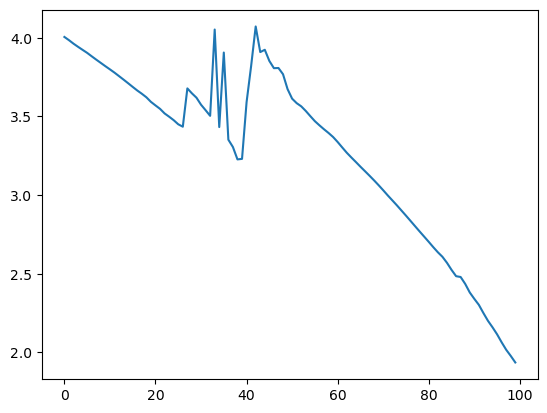

In [57]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

In [58]:
# building a fresh copy of the model to train from scratch since the training step is working
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [59]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [ ]:
train_translator.fit(dataset, epochs=120,
                     callbacks=[batch_loss])

Epoch 1/120


2023-03-08 14:26:48.479504: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] function_optimizer failed: INVALID_ARGUMENT: Input 6 of node StatefulPartitionedCall/gradient_tape/while/while_grad/body/_582/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/PartitionedCall was passed variant from StatefulPartitionedCall/gradient_tape/while/while_grad/body/_582/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.
2023-03-08 14:26:48.599687: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: OUT_OF_RANGE: src_output = 25, but num_outputs is only 25
2023-03-08 14:26:48.707337: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:134] tfg_optimizer{tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export} failed: INVALID_ARGUMENT: Result #25 of node 'StatefulPartitionedCall/while/body/_57/while/decoder_2/gru_5/Part

373/373 [==============================] - 171s 439ms/step - batch_loss: 4.9906
Epoch 2/120
373/373 [==============================] - 156s 419ms/step - batch_loss: 4.1298
Epoch 3/120
373/373 [==============================] - 156s 418ms/step - batch_loss: 3.4574
Epoch 4/120
373/373 [==============================] - 160s 428ms/step - batch_loss: 2.8311
Epoch 5/120
373/373 [==============================] - 157s 421ms/step - batch_loss: 2.2953
Epoch 6/120
373/373 [==============================] - 158s 423ms/step - batch_loss: 1.8278
Epoch 7/120
373/373 [==============================] - 158s 424ms/step - batch_loss: 1.4412
Epoch 8/120
373/373 [==============================] - 155s 416ms/step - batch_loss: 1.0723
Epoch 9/120
373/373 [==============================] - 155s 416ms/step - batch_loss: 0.7786
Epoch 10/120
373/373 [==============================] - 155s 416ms/step - batch_loss: 0.5384
Epoch 11/120
373/373 [==============================] - 157s 421ms/step - batch_loss: 0.358

In [ ]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [ ]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

In [ ]:
# converting token IDs to human readable text
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [ ]:
Translator.tokens_to_text = tokens_to_text

In [ ]:
# inputting random token IDs to see what it generates
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

In [ ]:
# takes the decoder's logit outputs and samples token IDs from that distribution
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)
  
  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [ ]:
Translator.sample = sample

In [ ]:
# testing the function on random i/p
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

In [ ]:
# implementing text to text translation loop
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


In [ ]:
Translator.translate = translate_unrolled

In [ ]:
# TESTING
%%time
input_text = tf.constant([
    'Waise really miss those days...', 
    'Yahi haal hai', 
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

In [ ]:
#@title [Optional] Use a symbolic loop
def translate_symbolic(self,
                       input_text,
                       *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  shape_checker = ShapeChecker()
  shape_checker(input_text, ('batch',))

  batch_size = tf.shape(input_text)[0]

  # Encode the input
  input_tokens = self.input_text_processor(input_text)
  shape_checker(input_tokens, ('batch', 's'))

  enc_output, enc_state = self.encoder(input_tokens)
  shape_checker(enc_output, ('batch', 's', 'enc_units'))
  shape_checker(enc_state, ('batch', 'enc_units'))

  # Initialize the decoder
  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)
  shape_checker(new_tokens, ('batch', 't1'))

  # Initialize the accumulators
  result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
  attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  shape_checker(done, ('batch', 't1'))

  for t in tf.range(max_length):
    dec_input = DecoderInput(
        new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    attention = attention.write(t, dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)
    shape_checker(dec_result.logits, ('batch', 't1', 'vocab'))
    shape_checker(new_tokens, ('batch', 't1'))

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens = result_tokens.write(t, new_tokens)

    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  result_tokens = result_tokens.stack()
  shape_checker(result_tokens, ('t', 'batch', 't0'))
  result_tokens = tf.squeeze(result_tokens, -1)
  result_tokens = tf.transpose(result_tokens, [1, 0])
  shape_checker(result_tokens, ('batch', 't'))

  result_text = self.tokens_to_text(result_tokens)
  shape_checker(result_text, ('batch',))

  if return_attention:
    attention_stack = attention.stack()
    shape_checker(attention_stack, ('t', 'batch', 't1', 's'))

    attention_stack = tf.squeeze(attention_stack, 2)
    shape_checker(attention_stack, ('t', 'batch', 's'))

    attention_stack = tf.transpose(attention_stack, [1, 0, 2])
    shape_checker(attention_stack, ('batch', 't', 's'))

    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [ ]:
Translator.translate = translate_symbolic

In [ ]:
# RUN THIS
result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

In [ ]:
%%time
three_input_text = tf.constant(['sabse best friend', 
                                'That toh I know',
                                'She was bhunnoing the masalas jub phone ki ghuntee bugee',
                                'tum batao',
                                'kya karna hai'
])

result = translator.tf_translate(three_input_text)
print(result['text'])
for tr in result['text']:
  print(tr.numpy().decode())

print()

In [ ]:
tf.saved_model.save(translator, 'translator',
                    signatures={'serving_default': translator.tf_translate})

In [ ]:
reloaded = tf.saved_model.load('translator')
result = reloaded.tf_translate(three_input_text)

In [ ]:
%%time
result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()